# Interface Analysis
Here we obtain interfacial residues from parsing the EBI PISA output files. We then assign these residues to monomers in the higher order complexes and highlight them.

## Parsing PISA
PISA outputs files as human-readable .txt files. This makes them tricky to parse. We focus on splitting the file on blank lines into chunk and scraping the relevant information from the chunks of interest

In [20]:
import os
import re
import itertools
from io import StringIO
from collections import OrderedDict
import pandas as pd

In [21]:
class interface_pocket_analysis(object):
    """Contains methods for parsing EBI PISA output interface .txt files"""
    def __init__(self, protein):
        self.protein = protein
        self.interface_path = 'interfaces/' + protein
        self.interfaces = self.get_interface_filenames()
    
    def get_interface_filenames(self):
        files =  os.listdir('interfaces/')
        return [f for f in files if self.protein in f]
    
    def parse_interface_one_residues(self):
        dfs = []
        for i in range(len(self.interfaces)):
            dfs.append(self._parse_interfaces('interfaces/' + self.interfaces[i], chunk=7))      
        return dfs

    def parse_interface_two_residues(self):
        dfs = []
        for i in range(len(self.interfaces)):
            dfs.append(self._parse_interfaces('interfaces/' + self.interfaces[i], chunk=10))      
        return dfs
    
    def _parse_interfaces(self, file_path, chunk):
        print(file_path)
        # Split file into list of chunks
        f = self.split_on_empty_lines(open(file_path).read())
        f = f[chunk].replace('| |', '|n|')
        # insert | between residues and number for 4 digit residue positions which don't have a preceding space.
        f = re.sub(r"([a-zA-Z])([0-9])", r"\1 | \2", f)
        f = f.replace(' ', '|')
        f = re.sub(r'(\|)\1+', r'\1', f)
        #Remove problematic HS columns
        f = f.replace('|H|', '|')
        f = f.replace('|S|', '|')
        f = f.replace('|HS|', '|')
        # Remove header lines
        f = f.split('\n')[4:-1]
        # Remove leading '|'
        f = [a[1:] for a in f]
        # Join list of strings on newlines
        f = '\n'.join(f)
        f = f.replace('|', ',')[1:]
        # Prep for pandas conversion
        F = StringIO(f)
        df = pd.read_csv(F, sep=",", header=None)
        # Select interface residues
        df = df.loc[df[1] == 'I']
        columns = ['idx', 's|i', 'residue', 'res_num', 'asa', 'bsa', 'delta_G']
        return df
    
    def get_hbonds(self, chunk):
        f = self.f[chunk].replace(' ', '|')
        f = re.sub(r'(\|)\1+', r'\1', f)
        f = f.replace('|H|', '|')
        f = f.replace('|S|', '|')
        f = f.split('\n')[4:-1]
        f = [a[1:] for a in f]
        f = '\n'.join(f)
        f = f.replace('|', ',')[1:]
        return df
        
    def read_pocket_residues(self, pocket_path):
        f = open(filepath, 'r').read()   
        f = f.splitlines()
        f = f[20:-2]
        f = [re.sub('\s+', ',', g) for g in f]
        f = '\n'.join(f)
        columns = ['atom', '']
        F = StringIO(f)
        df = pd.read_csv(F, sep=',', header=None)
        df['res_ind'] = df[4]+':'+df[3]+':'+ df[5].astype(str)
        #df.columns = ['atom', 'atom_num', 'atom_type', 'residue', 'chain', 'res_num', ]
        return df
        
    @staticmethod
    def split_on_empty_lines(s):
        # greedily match 2 or more new-lines
        blank_line_regex = r"(?:\r?\n){2,}"
        return re.split(blank_line_regex, s.strip())

#print(interface_pocket_analysis('wS_trimer-IGHV3-30-3-Conf1-6NB6').get_interface_filenames())
print(interface_pocket_analysis('wS_homotrimer_treated-Conf2-6ACD').parse_interface_one_residues())
#print(interface_pocket_analysis('wS_trimer-IGHV3-30-3-Conf1-6NB6').parse_interface_two_residues())

interfaces/wS_homotrimer_treated-Conf2-6ACD.interface_2.txt
interfaces/wS_homotrimer_treated-Conf2-6ACD.interface_1.txt
interfaces/wS_homotrimer_treated-Conf2-6ACD.interface_3.txt
[           0  1      2     3       4      5     6
38      39.0  I  A:GLN    39  147.43   5.27 -0.09
279    280.0  I  A:GLN   280  102.99  32.48  0.52
280    281.0  I  A:THR   281   17.76   0.25 -0.00
281    282.0  I  A:SER   282   57.94   2.45 -0.03
282    283.0  I  A:ASN   283   82.52  63.59 -0.39
...      ... ..    ...   ...     ...    ...   ...
1049  1050.0  I  A:VAL  1050   90.92   4.42 -0.05
1050  1051.0  I  A:SER  1051   41.83  29.15 -0.25
1051  1052.0  I  A:GLY  1052   62.65   2.44  0.04
1055  1056.0  I  A:VAL  1056   92.92  53.84  0.75
1057  1058.0  I  A:ILE  1058  139.57  23.52  0.38

[160 rows x 7 columns],            0  1      2     3       4       5     6
24      25.0  I  A:TYR    25   44.28   25.64  0.41
26      27.0  I  A:ASP    27   45.41    4.05 -0.05
27      28.0  I  A:GLU    28  152.20  125

### Obtain Interface Residues for each complex

In [22]:
def get_interface_residue_dict(files):
    interface_dict = {}
    for f in files:
        print(f)

        # Parse interface residues 
        interface_one = interface_pocket_analysis(f).parse_interface_one_residues()
        interface_two = interface_pocket_analysis(f).parse_interface_two_residues()
    
        # Combine and store residue arrays in a dictionary
        interfaces = pd.concat(interface_one + interface_two)
        interface_dict[f] = interfaces
    return interface_dict

# Get Intraviral Complexes
iv_files = os.listdir('structures/korkin_lab/IntraViralComplexes')
iv_files = [f[:-4] for f in iv_files if f.endswith('.pdb')]
print(iv_files)
intraviral_interfaces = get_interface_residue_dict(iv_files)

# Get Viral Human Complexes
vh_files = os.listdir('structures/korkin_lab/ViralHumanComplexes/')
vh_files = [f[:-4] for f in vh_files if f.endswith('.pdb')]
print(vh_files)
viral_human_interfaces = get_interface_residue_dict(vh_files)

['wN-Nterminal_domain_homopentamer-4UD1', 'wS_homotrimer-Conf2-5X5B', 'wNsp3-domain2_homotetramer-2acf', 'wNsp3-domain3_homotetramer-2wct', 'wNsp4_homodimer-3vc8', 'wE_homopentamer-5X29', 'wS_homotrimer-Conf1-5X58', 'wN-Cterminal_domain_homodimer-2JW8', 'wS_homotrimer-Conf1-6CS0', 'wNsp7-wNsp8-wNsp12_heterotetramer-6nur', 'wNsp9_tetramer-3ee7', 'wNsp5_homodimer-2gt7', 'wNsp10_dodecamer-2g9t', 'wNsp13_homodimer-6jyt', 'wNsp10-wNsp14_heterodimer-5c8u', 'wS_homotrimer-Conf2-6CS1', 'wS_homotrimer_treated-Conf1-6ACC', 'wS_homotrimer_treated-Conf2-6ACD', 'wNsp10-wNsp16_heterodimer-2xyq']
wN-Nterminal_domain_homopentamer-4UD1
interfaces/wN-Nterminal_domain_homopentamer-4UD1.interface_8.txt
interfaces/wN-Nterminal_domain_homopentamer-4UD1.interface_1.txt
interfaces/wN-Nterminal_domain_homopentamer-4UD1.interface_5.txt
interfaces/wN-Nterminal_domain_homopentamer-4UD1.interface_4.txt
interfaces/wN-Nterminal_domain_homopentamer-4UD1.interface_3.txt
interfaces/wN-Nterminal_domain_homopentamer-4UD1

## Visualise Interfaces

In [5]:
from ipymol import viewer as pymol

wNsp7-wNsp8-wNsp12_heterotetramer-6nur
57
64
93
LONG QUERY
0
select interface_A, interface_A or resi 287+288+289+291+331+389+390+392+393+398+399+401+402+403+407+550+559+298+299+301+304+308
32


IntProgress(value=0, max=48)

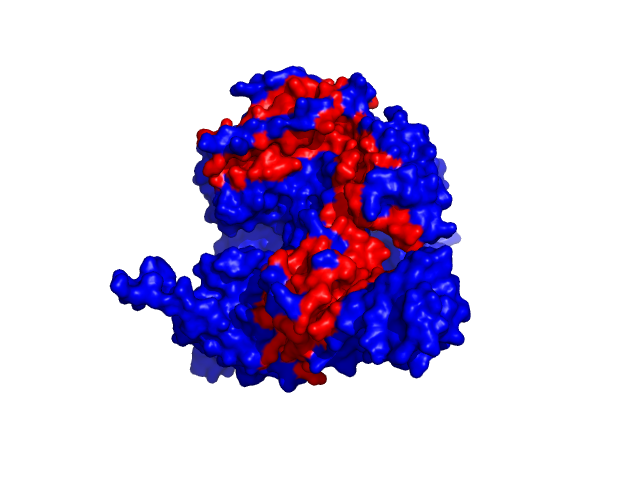

In [66]:
def visualise_interfaces(interface_dict, path_stem, protein, extension='.pse'):
    print(protein)
    pymol.deleteAll()
    # Load structure, split chains and display as surface
    pymol.do(f'load {os.getcwd()}/structures/{path_stem}{protein}' + '.pdb')
    pymol.do('split_chains')
    pymol.show_as('surface')
    pymol.do('color blue')
    
    # Retrieve interface dataframes from dictionary
    interface_residues = interface_dict[protein]      
    
    # Identify chains to iterate selections over
    chains = set([r[0] for r in interface_residues[2]])
    
    
    for chain in chains:
        # Select interface residues for chains and color them red
        s = interface_residues.loc[interface_residues[2].str.startswith(chain)]
        print(len(s))
        
        num_queries = int(len(s)/70)
        
        selection_query =  f'select interface_{chain}, chain {chain} and resi {s[3][0:70].astype(int).astype(str).str.cat(sep="+")}'
        pymol.do(selection_query)
        
        for i in range(num_queries):
            selection_query = f'select interface_{chain}, interface_{chain} or resi {s[3][70*(i+1)+1:70*(i+1)+1+70].astype(int).astype(str).str.cat(sep="+")}'
            print(selection_query)
            pymol.do(selection_query)
        
        # Colour selection and write
        pymol.do(f'color red, interface_{chain}')
        pymol.do(f'save pymol_files/interfaces/{path_stem}{protein}{extension}')

        
# Test function works        
visualise_interfaces(interface_dict=intraviral_interfaces,
                     path_stem='korkin_lab/IntraViralComplexes/',
                     protein='wNsp7-wNsp8-wNsp12_heterotetramer-6nur',
                     extension='.pse')
pymol.display()

### Write Interface Pymol Sessions

In [67]:
#### Korkin Lab Complexes
### Intraviral Complexes
path_stem = 'korkin_lab/IntraViralComplexes/'
files = os.listdir('structures/' + path_stem)
files = [f[:-4] for f in files if f.endswith('.pdb')]
[visualise_interfaces(interface_dict=intraviral_interfaces,
                      path_stem=path_stem,
                      protein=f,
                      extension='.pse') for f in files]

### ViralHuman Complexes
path_stem = 'korkin_lab/ViralHumanComplexes/'
files = os.listdir('structures/' + path_stem)
files = [f[:-4] for f in files if f.endswith('.pdb')]
[visualise_interfaces(interface_dict=viral_human_interfaces,
                      path_stem=path_stem,
                      protein=f,
                      extension='.pse') for f in files]

wN-Nterminal_domain_homopentamer-4UD1
22
47
30
37
28
wS_homotrimer-Conf2-5X5B
348
LONG QUERY
0
select interface_C, interface_C or resi 2768+2769+2770+2771+2772+2773+2774+2775+2776+2777+2778+2779+2780+2781+2782+2784+2787+2791+2792+2793+2794+2795+2796+2797+2798+2799+2819+2820+2821+2823+2824+2850+2851+2852+2853+2867+2870+2871+2872+2873+2874+2875+2876+2901+2902+2904+2905+2906+2907+2908+2909+2910+2911+2912+2913+2914+2915+2916+2917+2918+2919+2920+3152+3162+3163+3166+3169+3170+3173+3174
LONG QUERY
1
select interface_C, interface_C or resi 3175+3176+3177+3200+3204+3207+3208+3211+3214+3215+3218+3221+3222+3225+3229+3243+3244+3245+3246+3247+3250+3251+3252+3273+3274+3275+3277+3279+3282+3283+3284+3294+3295+3296+3297+3298+3299+3300+3312+3313+3326+3327+2243+2245+2246+2247+2248+2249+2250+2251+2252+2254+2293+2318+2320+2337+2370+2372+2373+2375+2401+2403+2404+2405+2407+2411+2429+2430+2431+2433
LONG QUERY
2
select interface_C, interface_C or resi 2435+2436+2437+2438+2439+2487+2488+2574+2575+2617+2618+2619

[None, None, None, None, None, None, None, None]